# ML model training

## Start by importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,9)

## Load and clean the data

In [20]:
df = pd.read_csv('data/sleepdata.csv', sep=';', parse_dates=['Start', 'End'])
df['Start time'] = pd.Series([val.time() for val in df['Start']])
df['End time'] = pd.Series([val.time() for val in df['End']])
df['Start time in second'] = df['Start time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df['End time in second'] = df['End time'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df['Time in bed'] = df['End'] - df['Start']
df['Time in bed'] = df['Time in bed'].astype('timedelta64[s]') # in seconds
# convert sleep quality to float:
df['Sleep quality'] = df['Sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
df['Wake up'] = df['Wake up'].replace({':)':2, ':|':1, ':(':0})
df.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps),Start time,End time,Start time in second,End time in second
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,2.0,NaN,59.0,0,22:57:49,07:30:13,82669,27013
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,1.0,Stressful day,72.0,0,21:17:50,21:33:54,76670,77634
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,1.0,NaN,57.0,0,22:42:49,07:13:31,81769,26011
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,NaN,NaN,NaN,0,22:31:01,06:03:01,81061,21781
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,2.0,Drank coffee:Drank tea,68.0,0,22:12:10,04:56:35,79930,17795


In [21]:
df['External_fact']=0
df.loc[~df['Sleep Notes'].isna(), 'External_fact' ]=1

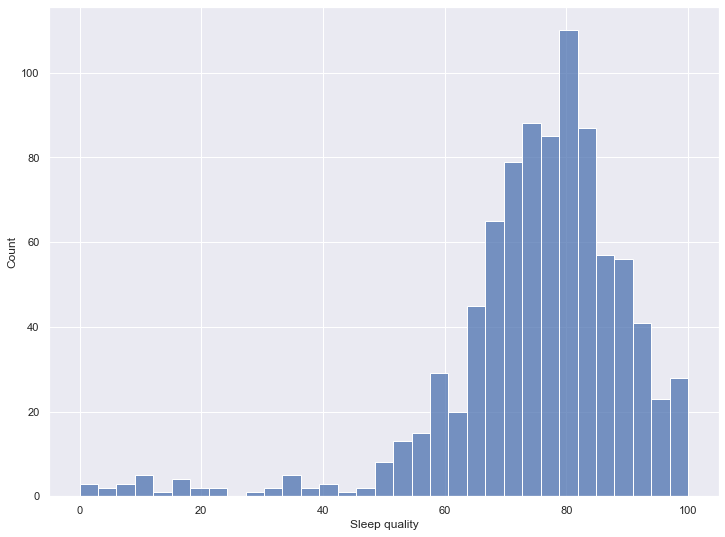

In [22]:
sns.set_theme()
plot = sns.histplot(df, x='Sleep quality')
# plot.set_title('Sleep quality distribution')

c:\Users\kvankuijk\Documents\uni\IS\project_video\Intelligent_Systems\env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


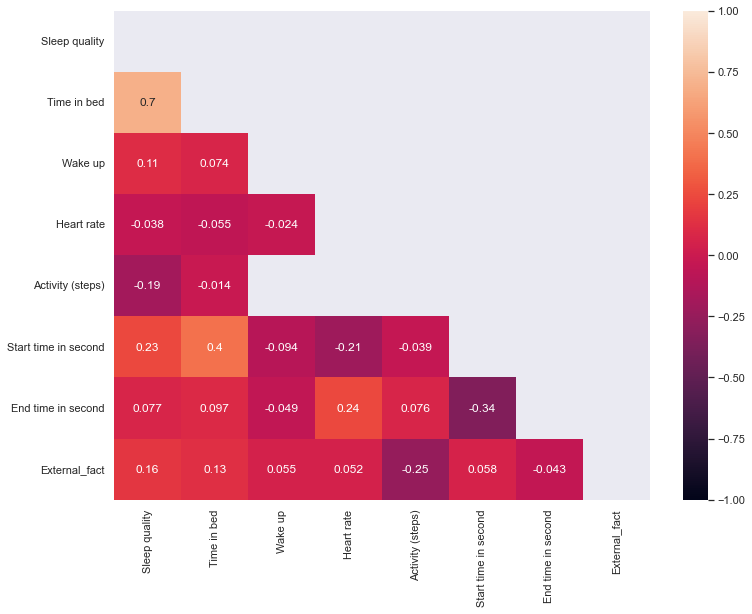

In [5]:
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
plot = sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1,)

In [23]:
df.dropna(inplace=True)
X = df[['Time in bed', 'Start time in second','End time in second','Activity (steps)','External_fact']].values
y = df['Sleep quality'].values

Train a basic model without hyperparameter tuning

In [10]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.2275092884079961

In [11]:
y_pred = rf.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

14.773909981079223

In [16]:
filename = 'finalized_model.joblib'
joblib.dump(rf, filename)

['finalized_model.joblib']

## Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

In [25]:
rf = RandomForestRegressor()
df.dropna(inplace=True)
X = df[['Time in bed', 'Start time in second','End time in second','Activity (steps)','External_fact']].values
y = df['Sleep quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
n_estimators = range(1,200,2)
max_depth= range(1,100,1)
min_samples_split=range(2,10,1)
min_samples_leaf=range(1,10,1)
grid = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

In [28]:
from scipy.stats import uniform, geom, loguniform, randint, expon
from sklearn.model_selection import RandomizedSearchCV

In [29]:
import warnings
warnings.simplefilter("ignore")
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

N_ITER = 100
N_JOBS = 1
K_FOLDS = 10
N_ITER_NO_CHANGE = 100
RANDOM_STATE = 10
SCORING_METRIC = 'neg_root_mean_squared_error'

hyper_parameters = {
        'n_estimators': randint(50,500),
        'max_depth': randint(3,10),
        'min_samples_split': randint(2,20),
        'random_state': [RANDOM_STATE],
        'min_samples_leaf': randint(1,10)
}

search_space = RandomizedSearchCV(
    rf, hyper_parameters, 
    n_iter = N_ITER, cv=K_FOLDS,
    scoring=SCORING_METRIC, n_jobs = N_JOBS, 
    return_train_score=True, verbose = 1
)
search_space.fit(X_train, y_train) 

y_pred = search_space.best_estimator_.predict(X_train)
y_pred_prob = search_space.best_estimator_.predict(X_train)
y_pred_test = search_space.best_estimator_.predict(X_test)

print( 
    'Best Training Score: ', search_space.cv_results_['mean_train_score'][search_space.best_index_], 
    '\nBest Test Score: ', search_space.best_score_,
)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Training Score:  -9.828073100696571 
Best Test Score:  -10.741648372224702


In [30]:
search_space_df = pd.DataFrame(search_space.cv_results_)

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_train_score'>

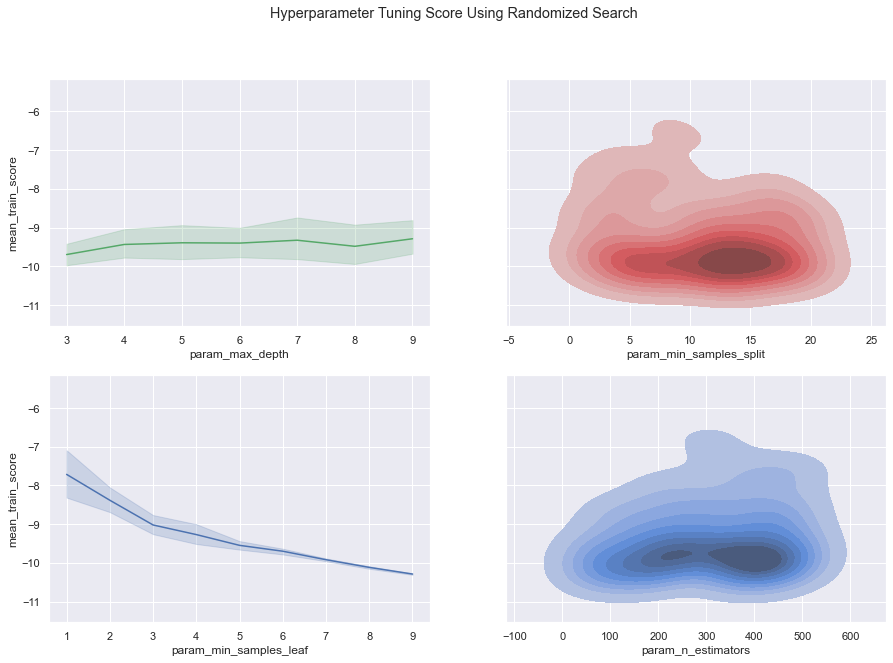

In [32]:
# relplot lineplot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
fig.suptitle('Hyperparameter Tuning Score Using Randomized Search')

sns.lineplot(data = search_space_df, x='param_max_depth', y='mean_train_score', color='g',
             ax=axes[0][0])

sns.kdeplot(data = search_space_df, x='param_min_samples_split', y='mean_train_score', shade=True, color='r',
             ax=axes[0][1])

sns.lineplot(data = search_space_df, x='param_min_samples_leaf', y='mean_train_score', 
            # shade=True, color='r',
             ax=axes[1][0])

sns.kdeplot(
    data=search_space_df,
    x="param_n_estimators", y="mean_train_score", shade=True)

In [33]:
search_space_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_random_state,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.211462,0.024294,0.016806,0.002436,6,7,16,226,10,"{'max_depth': 6, 'min_samples_leaf': 7, 'min_s...",...,-10.383545,-8.093943,-10.010751,-10.339094,-9.557918,-10.145882,-10.070211,-10.162177,-9.918319,0.645534
1,0.094466,0.008542,0.008024,0.000547,3,7,5,105,10,"{'max_depth': 3, 'min_samples_leaf': 7, 'min_s...",...,-10.638510,-8.280509,-10.194851,-10.552325,-9.694967,-10.321192,-10.267122,-10.321160,-10.111984,0.657029
2,0.344085,0.025461,0.031916,0.019477,4,1,2,386,10,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",...,-8.263829,-6.865952,-7.570096,-7.976833,-7.196521,-7.711218,-7.740505,-7.665520,-7.658592,0.369565
3,0.351130,0.047944,0.025174,0.003973,7,2,4,328,10,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",...,-7.785315,-5.772214,-7.176184,-7.566538,-6.748541,-7.215738,-7.051324,-7.231530,-7.129320,0.524698
4,0.221980,0.031848,0.013982,0.003096,4,7,14,217,10,"{'max_depth': 4, 'min_samples_leaf': 7, 'min_s...",...,-10.407748,-8.130046,-10.006656,-10.372948,-9.555614,-10.175907,-10.067554,-10.179353,-9.936752,0.643373


### Get results:

In [34]:
search_space.best_estimator_

RandomForestRegressor(max_depth=3, min_samples_leaf=5, min_samples_split=6,
                      n_estimators=250, random_state=10)

In [35]:
search_space.best_score_

-10.741648372224702